In [570]:
# Importing Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from dateutil import parser
from sklearn.model_selection import cross_val_score

In [571]:
# Loading the data
sales_df = pd.read_csv('sales.csv')
real_sales_df = pd.read_csv('REAL_DATA.csv')
real_sales_df.shape

(71205, 9)

In [572]:
# Exploring the data
sales_df.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [573]:
sales_df.day_of_week.unique()

array([4, 6, 2, 7, 3, 5, 1], dtype=int64)

In [574]:
sales_df.describe().round()

,Unnamed: 0,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,sales
count,640840.0,640840.0,640840.0,640840.0,640840.0,640840.0,640840.0,640840.0
mean,355991.0,558.0,4.0,633.0,1.0,0.0,0.0,5777.0
std,205536.0,322.0,2.0,464.0,0.0,0.0,0.0,3851.0
min,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,178076.0,280.0,2.0,405.0,1.0,0.0,0.0,3731.0
50%,355948.0,558.0,4.0,609.0,1.0,0.0,0.0,5746.0
75%,533959.0,837.0,6.0,838.0,1.0,1.0,0.0,7860.0
max,712044.0,1115.0,7.0,5458.0,1.0,1.0,1.0,41551.0


In [575]:
print(f"Shape:\n{sales_df.shape}\n")
print(f"Types:\n{sales_df.dtypes}")

Shape:
(640840, 10)

Types:
Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object


In [576]:
# Checking to see if every value in Unnamed: 0 is unique. Which will mean it's and 'id' column and we can drop it
if sales_df['Unnamed: 0'].unique().__len__() == sales_df.shape[0]:
    sales_df = sales_df.drop('Unnamed: 0', axis=1)

if real_sales_df['index'].unique().__len__() == real_sales_df.shape[0]:
    real_sales_df = real_sales_df.drop('index', axis=1)

sales_df.head()

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,2013-04-18,517,1,0,0,0,4422
1,394,6,2015-04-11,694,1,0,0,0,8297
2,807,4,2013-08-29,970,1,1,0,0,9729
3,802,2,2013-05-28,473,1,1,0,0,6513
4,726,4,2013-10-10,1068,1,1,0,0,10882


In [577]:
# Checking for missing data
print(sales_df.isnull().sum())

store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64


In [578]:
print(sales_df['state_holiday'].unique())

['0' 'a' 'c' 'b']


In [579]:
### TEST DATA ###
# Replace non-int data in the 'date' and 'state_holiday' columns with integers

# Converting the string values to integers
sales_df['state_holiday'] = sales_df['state_holiday'].replace('0', 0)
sales_df['state_holiday'] = sales_df['state_holiday'].replace('a', 1)
sales_df['state_holiday'] = sales_df['state_holiday'].replace('b', 2)
sales_df['state_holiday'] = sales_df['state_holiday'].replace('c', 3)

# Converting the dates to a timestamp
if type(sales_df['date'][0]) == str:
    sales_df['date'] = sales_df['date'].apply(lambda x: int(parser.parse(x).timestamp()))

# Checking the result
print(sales_df['state_holiday'].unique())
sales_df.head()

C:\Users\Javi\AppData\Local\Temp\ipykernel_108228\2794111588.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_df['state_holiday'] = sales_df['state_holiday'].replace('c', 3)


[0 1 3 2]


,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,1366236000,517,1,0,0,0,4422
1,394,6,1428703200,694,1,0,0,0,8297
2,807,4,1377727200,970,1,1,0,0,9729
3,802,2,1369692000,473,1,1,0,0,6513
4,726,4,1381356000,1068,1,1,0,0,10882


In [580]:
### REAL DATA ###
# Replace non-int data in the 'date' and 'state_holiday' columns with integers

# Converting the string values to integers
real_sales_df['state_holiday'] = real_sales_df['state_holiday'].replace('0', 0)
real_sales_df['state_holiday'] = real_sales_df['state_holiday'].replace('a', 1)
real_sales_df['state_holiday'] = real_sales_df['state_holiday'].replace('b', 2)
real_sales_df['state_holiday'] = real_sales_df['state_holiday'].replace('c', 3)

# Converting the dates to a timestamp
if type(real_sales_df['date'][0]) == str:
    real_sales_df['date'] = real_sales_df['date'].apply(lambda x: int(parser.parse(x).timestamp()))

# Checking the result
print(real_sales_df['state_holiday'].unique())
real_sales_df.head()

C:\Users\Javi\AppData\Local\Temp\ipykernel_108228\983981005.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  real_sales_df['state_holiday'] = real_sales_df['state_holiday'].replace('c', 3)


[0 1 2 3]


,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday
0,415,7,1420239600,0,0,0,0,0
1,27,7,1388271600,0,0,0,0,0
2,404,3,1395183600,657,1,1,0,0
3,683,2,1359414000,862,1,0,0,0
4,920,3,1395183600,591,1,1,0,0


sns.pairplot(sales_df.drop('date', axis=1).sample(100))
plt.show()

# Creating a correlation matrix
corr = sales_df.drop('date', axis=1).corr()

# Ploting a heatmap of the correlation between the different columns
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [591]:
from sklearn.model_selection import KFold

# Defining Features and Target an Standarizing the data
# TODO: SHOULD WE NORMALIZE?
X_scaled = StandardScaler().fit_transform(sales_df.drop('sales', axis=1))
X_scaled_real = StandardScaler().fit_transform(real_sales_df)
y = sales_df['sales']

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True) #, random_state=42
sum_r2 =0

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize and fit the XGBoost Regressor model
    xgb_model = xgb.XGBRegressor().fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    sum_r2 += r2
    print(f'R² Score: {r2.round(4)}')
print(f'\nAverage R² Score: {(sum_r2/n_splits).round(4)}')


R² Score: 0.9327
R² Score: 0.9331
R² Score: 0.9319
R² Score: 0.9328
R² Score: 0.9321

Average R² Score: 0.9325


In [566]:
# Defining Features and Target an Standarizing the data
# TODO: SHOULD WE NORMALIZE?
X_scaled = StandardScaler().fit_transform(sales_df.drop('sales', axis=1))
X_scaled_real = StandardScaler().fit_transform(real_sales_df)
y = sales_df['sales']

# TODO: CHECK WITH DIFFERENT SPLITS
# Splitting the data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.10, random_state=42) # DO WE NEED random_state?

# Initialize and fit the XGBoost Regressor model
xgb_model = xgb.XGBRegressor().fit(X_train, y_train)

In [567]:
# Make predictions
y_pred = xgb_model.predict(X_test)
#y_pred_real = xgb_model.predict(real_sales_df)
y_pred_real_scaled = xgb_model.predict(X_scaled_real) # TODO: DO WE WANT TO SCALE?

# Creating the CSV file to deliver
real_sales_df_final = real_sales_df
real_sales_df_final['sales'] = pd.DataFrame(y_pred_real_scaled, columns=['sales']).astype('int64')
real_sales_df_final.to_csv('G5.csv', index=False)

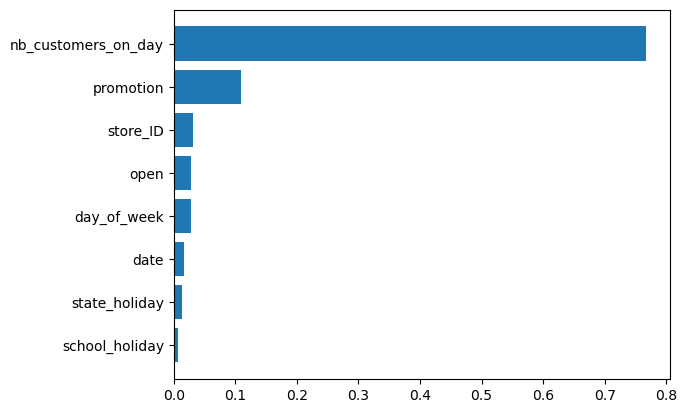

In [424]:
# Visualizing feature importance
sort_idx = xgb_model.feature_importances_.argsort()

plt.barh(X.columns[sort_idx],xgb_model.feature_importances_[sort_idx])
plt.show();

In [568]:
# Evaluate the model
#mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#print(f'Mean Squared Error: {mse.round(4)}')
print(f'R² Score: {r2.round(4)}')

# 0.9340315739468619

R² Score: 0.9326


In [594]:
# Perform Cross validation on the model to know it generalizes well and with small standard deviation, it indicates consistent performance
# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(xgb_model, X_scaled, y, cv=5, scoring='r2')

# Calculate mean and standard deviation of R² scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f'Cross-Validation R² Scores: {cv_scores}')
print(f'Average R² Score: {mean_cv_score:.4f}')
print(f'Standard Deviation of R² Score: {std_cv_score:.4f}')

Cross-Validation R² Scores: [0.93339551 0.93409604 0.93328492 0.93136618 0.93253395]
Average R² Score: 0.9329
Standard Deviation of R² Score: 0.0009
